## P1: De-beeper

Displaying Speech signal contaminated by a beep sound.

In [1]:
# Point-1 Checking input speech signal
from IPython.display import Audio
audio = Audio(filename='x.wav')
display(audio)

In [2]:
#Point-1: Loading x.wav file
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
(sampling_rate,amplitudes) = wavfile.read('x.wav')
print("Sampling Rate: ",sampling_rate)
print("Number of amplitudes: ",amplitudes.shape[0])
print("Range of amplitudes:",amplitudes.min(),"to",amplitudes.max())

Sampling Rate:  16000
Number of amplitudes:  63488
Range of amplitudes: -7431 to 8365


wavfile reads integer values which needs to be scaled down by dividing by its max value. So that the amplitude values are ranged between -1 and +1

In [3]:
max_value = max(abs(amplitudes.max()),abs(amplitudes.min()))
Norm_amplitudes = amplitudes/max_value
print("Range of Normalized amplitudes:",Norm_amplitudes.min(),"to",Norm_amplitudes.max())

Range of Normalized amplitudes: -0.888344291691572 to 1.0


### Discrete Fourier transform: $X[f]=  \sum_{n=0}^{N-1} x[n]*exp\{-j(2\pi f \frac{n}{N}) \}$

In [4]:
#Point-2: creating a DFT matrix F using the above equation
def dftmatrix(N):
    n=np.arange(N)
    f=n.reshape(-1,1)
    F_matrix= np.exp(-2j*np.pi*f*n/N)
    return F_matrix

In [5]:
#Trying DFT for N=16 ,N=1600 and  N=16000

F_16=dftmatrix(16)
F_1600=dftmatrix(1600)
F_16000=dftmatrix(16000)

In [6]:
def plot_dft(F):
    plt.suptitle("N = "+str(F.shape[0]))
    plt.subplot(1, 2, 1)
    plt.imshow(F.real)
    plt.title('Real')
    plt.subplot(1, 2, 2)
    plt.title('Imaginary')
    plt.imshow(F.imag)
    plt.tight_layout()

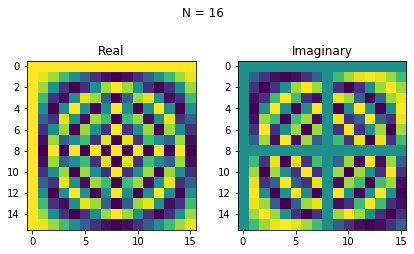

In [7]:
plot_dft(F_16)

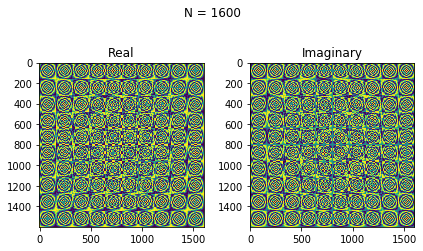

In [8]:
plot_dft(F_1600)

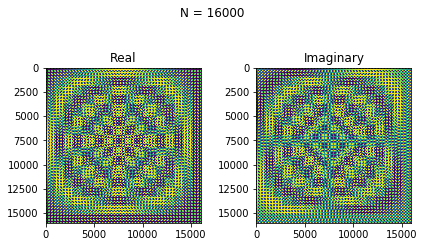

In [9]:
plot_dft(F_16000)

In [10]:
#considering
N=1600
F=F_1600
print("Shape of F matrix: ",F.shape)

Shape of F matrix:  (1600, 1600)


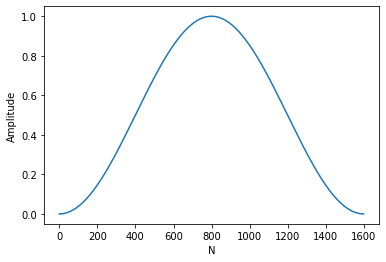

In [11]:
# Point-3: Prepare your data matrix X.
#Hanning Window 
hann=np.hanning(N)
plt.plot(hann)
plt.xlabel("N")
plt.ylabel("Amplitude")
plt.show()

In [12]:
# Point-3: Prepare your data matrix X.
n=int(amplitudes.shape[0]/(N/2))-1
X= []
for i in range(n):
    #Move by N/2 samples. 
    shift= int(i*N/2) 
    data=amplitudes[shift:N+shift] * hann
    X.append(data)
X=np.array(X)
X=X.T
X.shape

(1600, 78)

In [13]:
#Point-4: Apply the DFT matrix to  data matrix, i.e. FX.
F_X=np.matmul(F,X)

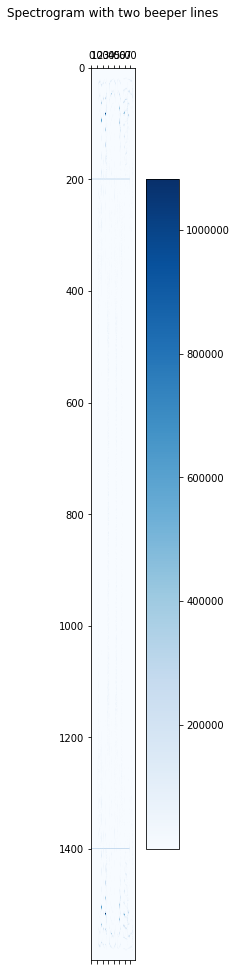

In [14]:
plt.matshow(abs(F_X),cmap="Blues")
plt.colorbar()
plt.title("Spectrogram with two beeper lines")
plt.show()


In [15]:
# Finding the rows corresponding to beeper lines
cv = abs(F_X).sum(axis=1)/max(abs(F_X).sum(axis=1))
np.sort(cv.argsort()[-6:][::-1])

array([ 199,  200,  201, 1399, 1400, 1401], dtype=int64)

In [16]:
#Removing beeper lines by making the corresponding rows(199 to 201 and 1399 to 1401) equal to  0
F_X[199:202]=0
F_X[1399:1402]=0

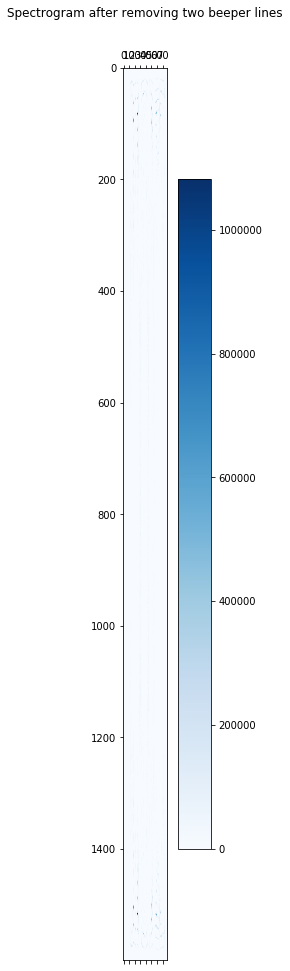

In [17]:
plt.matshow(abs(F_X),cmap="Blues")
plt.colorbar()
plt.title("Spectrogram after removing two beeper lines")
plt.show()


### Inverse transform: $x[n]=  \frac{1}{N}\sum_{f=0}^{N-1} X[f]*exp\{j(2\pi f \frac{n}{N}) \}$

In [18]:
#Point-5: Applying the inverse DFT matrix 
def Finv_matrix(N):
    n=np.arange(N)
    f=n.reshape(-1,1)
    F_inv= np.exp(2j*np.pi*f*n/N)
    return F_inv

F_star= Finv_matrix(N)

In [19]:
# X_hat Matrix (F*.FX)
X_hat=np.matmul(F_star,F_X)

#Considering only real-valued part of matrix
X_r=X_hat.real
X_r=X_r.T

Recovered_X=[]

for i in range(n-1):
    k=X_r[i][int(N/2):N]+X_r[i+1][0:int(N/2)]
    Recovered_X.append(k)
    Final_Recovered_X=np.concatenate(Recovered_X,axis=0)


In [20]:
#Recovered signal after removing beep tones
Audio(Final_Recovered_X, rate=16000)


# --------------------------------------------------------------------------------------------------------------

## P2: Parallax

In [21]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

june = scipy.io.loadmat('june.mat',mat_dtype=True)
june=june['june']

dec = scipy.io.loadmat('december.mat',mat_dtype=True)
dec=dec['december']

In [22]:
june.shape,dec.shape

((2700, 2), (2700, 2))

In [23]:
# For the x-coordinates of the stars
disparity = dec[:,0]-june[:,0]
disparity_y = dec[:,1]-june[:,1]

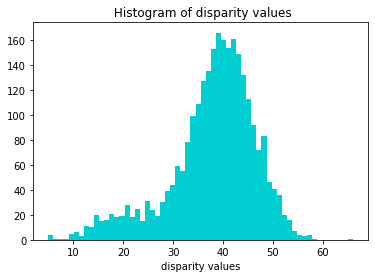

In [24]:
#Point-6 Histogram of disparity values to gauge to check if there are two clusters.
plt.hist(disparity, color = "darkturquoise", bins=60)
plt.title(' Histogram of disparity values')
plt.xlabel('disparity values')
plt.show()

#### Looks like there are two clusters with first one between 0 to 28 and rest of them form second cluster 
#### Let's Perform k-means clustering on this disparity dataset.

In [25]:
def K_means(n_clusters,data):

    cluster_centers = np.random.choice(data,n_clusters)

    while True:
        c1 = []
        c2 = []
        # Assigning points to c1 and c2 based on closest center
        for point in data:
            d1 = np.sqrt(np.square(cluster_centers[0]-point).sum()) # this works even for higher dimensions data
            d2 = np.sqrt(np.square(cluster_centers[1]-point).sum()) #np.abs(cluster_centers[1]-point) can be used for 1-D data

            if d1 < d2:
                c1.append(point)
            else:
                c2.append(point)
        # Finding new centers from means of points
        new_centers = np.array([np.mean(c1),np.mean(c2)])
        # Checking for convergence
        if np.all(cluster_centers == new_centers):
            return cluster_centers,[c1,c2]
        cluster_centers = new_centers
    

In [26]:
cluster_centers,clustered_points= K_means(2,disparity)
print("Center of first cluster: ",cluster_centers[0])
print("Center of second cluster: ",cluster_centers[1])

Center of first cluster:  27.74271844660194
Center of second cluster:  42.31183368869936


#### Statement in Assignment: 
Because of the pretty big movement of your planet due to its revolution, you can see that the close-by stars oscillate more in the two pictures than the far-away ones

Therefore, cluster with higher mean disparity i.e second cluster with center at 42.31 corresponds to the stars in our galaxy and first cluster corresponds to other galaxy

# --------------------------------------------------------------------------------------------------------------

## P3: GMM for Parallax

#### Lets take the mean ,variance and probability of two clusters we got from Kmeans and use those values for initialization in GMM.

In [27]:
mu = cluster_centers
c=clustered_points
var= np.array([np.var(c[0]),np.var(c[1])]) # standard deviation = sigma and variance = sigma^2
prob= np.array([np.divide(len(c[0]),len(c[0])+len(c[1])),np.divide(len(c[1]),len(c[0])+len(c[1]))])

In [28]:
print("K-Means Means: ",mu)
print("K-Means Variance: ",var)
print("K-Means Probabilities: ",prob)

K-Means Means:  [27.74271845 42.31183369]
K-Means Variance:  [48.17409746 19.2902864 ]
K-Means Probabilities:  [0.30518519 0.69481481]


#### Lets Implement EM algorithm for GMM
##### EM can be simplified in 2 phases: The E (expectation) and M (maximization) steps.
#####  In the E step, we calculate the likelihood of each observation using the estimated parameters. (calculation of posterior probabilities)

$ U_{i,j} = p(j|x_{i}) =  \frac {P_{j} N(\mu,\sigma)} {\sum P_{j} N(\mu,\sigma)} $

$ N(\mu,\sigma)= \frac{1}{\sqrt {2\pi \sigma^{2}}} exp(- \frac {(x-\mu)^{2}}{2\sigma^{2}}) $

In [29]:
def E_step(n_clusters,data,prob,var,mu):
    N=np.zeros((len(data), n_clusters))
    U=np.zeros((len(data), n_clusters))
    P_N=np.zeros((len(data), n_clusters))
    for j in range(n_clusters):
        N[:,j] = (1/np.sqrt(2*np.pi* var[j]))* np.exp((-1/2)*np.square((data-mu[j]))*(1/var[j]))
        P_N[:,j] =prob[j]*N[:,j]

    for j in range(n_clusters):
        U[:,j] = np.divide(P_N[:,j],P_N.sum(axis=1))
    
    return U
        

##### M-step: update parameters ( mu,sigma,prob)

$ mu_{j} = \frac {\sum_{i=1}^{N1} U_{i,j}*x_{i}} {\sum_{i=1}^{N1} U_{i,j}} $

$ P_{j} = \frac {\sum_{i=1}^{N1} U_{i,j}} {N1} $

$ variance_{j} = \frac {\sum_{i=1}^{N1} U_{i,j}*variance_{i,j}} {\sum_{i=1}^{N1} U_{i,j}} $


In [30]:
def M_step(n_clusters,U,data):
    mu=np.zeros(n_clusters)
    var=np.zeros(n_clusters)
    prob=np.zeros(n_clusters)
    for j in range(n_clusters):
        mu[j]=(U[:,j].dot(data))/sum(U[:,j])
        var[j] = (U[:,j].dot(np.square(data-mu[j])))/sum(U[:,j])
       # sigma[j] = np.sqrt((U[:,j].dot(np.square(data-mu[j])))/sum(U[:,j]))
        prob[j]=sum(U[:,j])/len(U[:,j])    
    return mu,var,prob
        

In [31]:
def GMM(n_clusters,data,prob,var,mu):
    e=0.00001
    delta =np.ones(n_clusters)*e
    while True: 
        U=E_step(n_clusters,data,prob,var,mu)
        new_mu,var,prob= M_step(n_clusters,U,data)
        # Checking for convergence
        if (np.abs(new_mu-mu)<=delta).sum()//2:
            return mu,var,prob,U
        mu = new_mu

In [32]:
GMM_mu,GMM_var,GMM_prob,U = GMM(2,disparity,prob,var,mu)

In [33]:
print("GMM Means: ",GMM_mu)
print("GMM variance: ",GMM_var)
print("GMM prior weights: ",GMM_prob)

GMM Means:  [20.84335271 40.15284744]
GMM variance:  [34.46010964 34.14168565]
GMM prior weights:  [0.11845413 0.88154587]


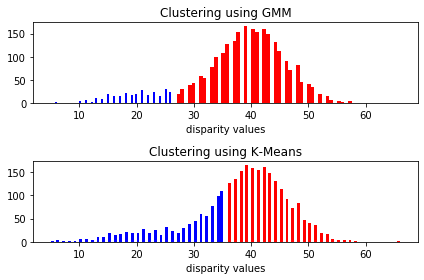

In [56]:
#Plotting results of GMM and K-Means
plt.subplot(2, 1, 1)
plt.hist(disparity[np.rint(U[:,0])>0], color = "Blue", bins=60)
plt.hist(disparity[np.rint(U[:,1])>0], color = "Red", bins=60)
plt.title('Clustering using GMM')
plt.xlabel('disparity values')
plt.subplot(2, 1, 2)
plt.hist(c[0], color = "Blue", bins=60)
plt.hist(c[1], color = "Red", bins=60)
plt.title('Clustering using K-Means')
plt.xlabel('disparity values')
plt.tight_layout()

I think GMM results are better for this use case over K-means' solution. We know K-means does Hard assignment of data points to a cluster, as it tries to find spherical distributions. While GMM does soft assignments by finding the probabilities of a point to follow certain Gaussian distributions. 

In the above graphs, it's weird to see points with disparity values in range 28 to 35(approx) assigned to the blue cluster as they look more likely to follow the distribution of the red cluster.

## P4: DCT and PCA

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
img=mpimg.imread('IMG_1878.JPG')


In [36]:
#Point-1 Loading image and dividing the 3D array (1024  768  3) into the three channels
X_R = img[:,:,0]
X_G = img[:,:,1]
X_B = img[:,:,2] 

Randomly choose 3 blocks of 8 consecutive rows from each of X_R, X_G and X_B.(i.e 9 blocks of 8 x 768). 
Then create a matrix R by concatenating all of them horizontally (i.e 8 x 6912 )

In [37]:
#Point-2: Creating R matrix
def create_R(img,blocks_per_channel):
    B=[]
    for col in range(3): # Looping over R,G and B
        for b in range(blocks_per_channel): # Looping for 3 samples from each color arrays
            first_row = random.randrange(0,img.shape[0]-8)
            block = img[first_row:first_row+8,:,col]
            B.append(block)
    R=np.concatenate(B,axis=1)
    return R

In [38]:
R_9 = create_R(img,3)
R_9.shape

(8, 6912)

In [39]:
#Point-2: Creating covariance matrix using R
#Subtract the mean
A_9 =R_9-np.mean(R_9)
#calculating the covariance matrix
cov_matrix_9 = np.matmul(A_9,A_9.T)/A_9.shape[1]
cov_matrix_9.shape

(8, 8)

In [40]:
#Point-2: Calculating 8 Eigenvectors 
E_val_9,E_vect_9=np.linalg.eigh(cov_matrix_9)

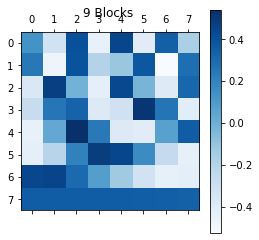

In [41]:
#Plot (Eigven Vector)T
plt.matshow(E_vect_9.T,cmap='Blues')
plt.colorbar()
plt.title("9 Blocks ")
plt.show()

In [42]:
#Point-3: Analysis with 90 blocks
R_90 = create_R(img,30)
R_90.shape

(8, 69120)

In [43]:
#Creating covariance matrix using R
#Subtract the mean
A_90 =R_90-np.mean(R_90)
#calculating the covariance matrix
cov_matrix_90 = np.matmul(A_90,A_90.T)/A_90.shape[1]
cov_matrix_90.shape

(8, 8)

In [44]:
#Calculating 8 Eigenvectors 
E_val_90,E_vect_90=np.linalg.eigh(cov_matrix_90)

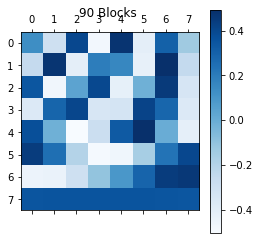

In [45]:
#Plot (Eigven Vector)T
plt.matshow(E_vect_90.T,cmap='Blues')
plt.colorbar()
plt.title("90 Blocks ")
plt.show()

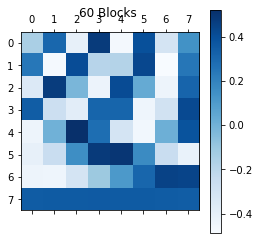

In [57]:
#Point-3: Analysis with 60 blocks
R = create_R(img,20)
R.shape
#Creating covariance matrix using R
#Subtract the mean
A =R-np.mean(R)
#calculating the covariance matrix
cov_matrix = np.matmul(A,A.T)/A.shape[1]
cov_matrix.shape
#Calculating 8 Eigenvectors 
E_val,E_vect=np.linalg.eigh(cov_matrix)
#Plot (Eigven Vector)T
plt.matshow(E_vect.T,cmap='Blues')
plt.colorbar()
plt.title("60 Blocks ")
plt.show()

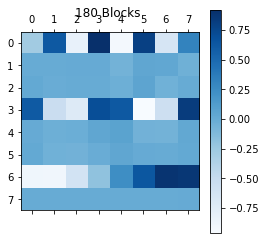

In [58]:
# EV comparision for blocks count 60 and 9
plt.matshow((E_vect-E_vect_9).T,cmap='Blues')
plt.colorbar()
plt.title("180 Blocks ")
plt.show()

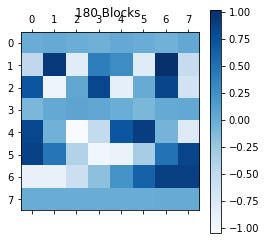

In [59]:
# EV comparision for blocks count 90 and 9
plt.matshow((E_vect_90-E_vect_9).T,cmap='Blues')
plt.colorbar()
plt.title("180 Blocks ")
plt.show()